# Как построить географическую карту с помощью языка программирования Python

План:

* Стандартные географические карты
* Интерактивные карты

Внимание! 

Для работы нам понадобятся две новые библиотеки: [Basemap](http://matplotlib.org/basemap/) и [Folium](https://github.com/python-visualization/folium), которые по умолчанию не входят в Anaconda Python Distribution.

Решение: Установим вручную с помощью пакетных менеджеров conda и pip.

Как?

1. Запускаем терминал (Ctrl+Alt+T)
2. В командной строке набираем: conda install basemap
3. В командной строке набираем: pip install folium

Переходим к следующему шагу только после успешной установки Basemap и Folium.

## Способ первый. Basemap

In [1]:
# загрузим стандартные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# загрузим библиотеку рисования географических карт Basemap
from mpl_toolkits.basemap import Basemap

# отображение рисунков внутри нашей среды разработки (jupyter notebook)
%matplotlib inline

In [3]:
# Используем файл с координатами водосборов из предыдущего занятия
# Построчно считываем файл
f = open("../Week3/usgs431.txt", 'r')

basin_id = []
basin_long = []
basin_lat = []
basin_area = []
for line in f:
    s = line.split()
    basin_id.append(s[0])
    basin_long.append(s[1])
    basin_lat.append(s[2])
    basin_area.append(s[3])

# Создаем рабочий DataFrame
basin_list = pd.DataFrame({'ID': basin_id, 
                           'long': basin_long, 
                           'lat': basin_lat, 
                           'area': basin_area})

# Переводим значения широты, долготы и площади в вещественный тип
basin_list['long'] = pd.to_numeric(basin_list['long'], errors='coerce')
basin_list['lat'] = pd.to_numeric(basin_list['lat'], errors='coerce')
basin_list['area'] = pd.to_numeric(basin_list['area'], errors='coerce')

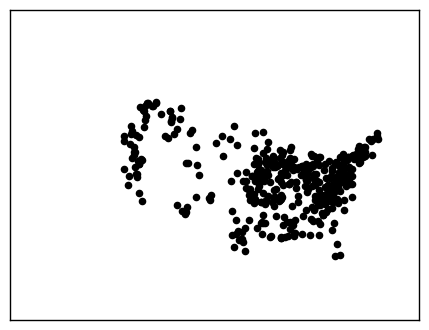

In [4]:
# Построим нашу первую карту с Basemap

# Создадим объект карты
# Присвоим объекту карты проекцию, область отображения и разрешение:
# projection='lcc' - проекция Lambert Conformal
# lat_0, lon_0 - центральные параллель и меридиан
# llcrnrlon, llcrnrlat - координаты левого нижнего угла карты
# urcrnrlon, urcrnrlat - координаты правого верхнего угла карты
# resolution='l' - низкое разрешение

m = Basemap(projection='lcc', 
            lat_0 = np.mean(basin_list['lat'].values), 
            lon_0 = np.mean(basin_list['long'].values),
            llcrnrlon=-130.0, llcrnrlat=10.0,
            urcrnrlon=-50.0, urcrnrlat=60.0,
            resolution='l')

# Трансформируем наши координаты
x, y = m(basin_list['long'].values, basin_list['lat'].values)

# Строим карту с отображением наших точек
# Функция работает аналогично plt.scatter, только рисование происходит в области геграфической проекции
m.scatter(x,y, 
          c='black', 
          marker='o')

{-120: ([<matplotlib.lines.Line2D at 0x7fa3e49f5358>], []),
 -80: ([<matplotlib.lines.Line2D at 0x7fa3e49f5b38>], [])}

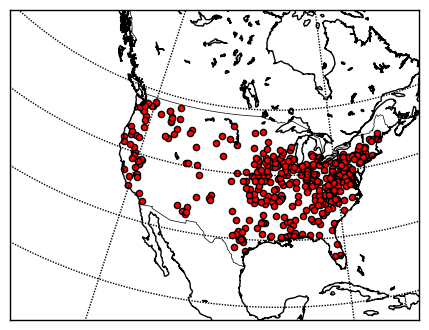

In [5]:
# В целом, полученный результат почти не отличается от полученного на предыдущей неделе
# Сделаем наш рисунок похожим на географическую карту

# Создаем основу
m = Basemap(projection='lcc', 
            lat_0 = np.mean(basin_list['lat'].values), 
            lon_0 = np.mean(basin_list['long'].values),
            llcrnrlon=-130.0, llcrnrlat=10.0,
            urcrnrlon=-50.0, urcrnrlat=60.0,
            resolution='l')

x, y = m(basin_list['long'].values, basin_list['lat'].values)

m.scatter(x,y, 
          c='red', 
          marker='o')

# добавляем очертания материков
m.drawcoastlines()

# добавляем очертания стран
m.drawcountries()

# добавляем координатные оси
m.drawparallels(np.arange(20, 60, 10))
m.drawmeridians(np.arange(-120, 20, 40))

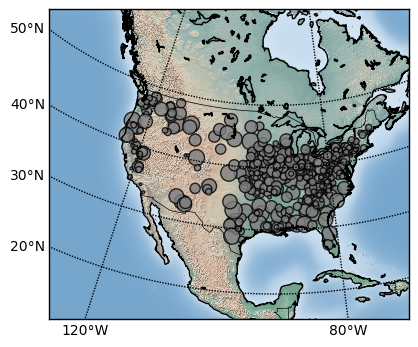

In [6]:
# Уже намного лучше!
# Такую карту уже можно добавлять в статью
# Добавим еще пару улучшений

# Создаем основу
m = Basemap(projection='lcc', 
            lat_0 = np.mean(basin_list['lat'].values), 
            lon_0 = np.mean(basin_list['long'].values),
            llcrnrlon=-125.0, llcrnrlat=10.0,
            urcrnrlon=-50.0, urcrnrlat=60.0,
            resolution='l')

x, y = m(basin_list['long'].values, basin_list['lat'].values)

# добавляем подложку с рельефом
m.shadedrelief()

# добавляем очертания материков и стран
m.drawcoastlines()
m.drawcountries()

# добавляем и подписываем наши координатные оси
m.drawparallels(np.arange(20, 60, 10), labels=[1, 0, 0, 1])
m.drawmeridians(np.arange(-120, 20, 40), labels=[1, 0, 0, 1])

# назначаем размер точки в соответствии с площадью бассейна
m.scatter(x,y, 
          s=basin_list['area']/basin_list['area'].min(),
          c='gray',
          alpha=0.8
         )

Ура, получаем полностью готовую к публикации карту распределения наших бассейнов

Рассмотрим случай, когда в качестве подложки нам нужно использовать поле среднегодовой температуры.

Для этого скачаем обощенные данные по климатическим нормам среднемесячной температуры воздуха.

In [7]:
# Данные уже находятся в нашем рабочем репозитории
# Для использования данных в других проектах используйте команду для скачивания:
# !wget ftp://ftp.cdc.noaa.gov/Datasets/udel.airt.precip/air.mon.ltm.v401.nc

In [7]:
# Файл средних температур в офрмате netcdf
# Используем стандартные инструменты для его чтения и обработки

# импортируем библиотеку scipy.io, реализующую функционал чтения netcdf
from scipy.io import netcdf

# откроем интересующий нас файл
nc = netcdf.netcdf_file('air.mon.ltm.v401.nc', maskandscale=True)

# считаем необходимые переменные
air = nc.variables['air'][:]
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]

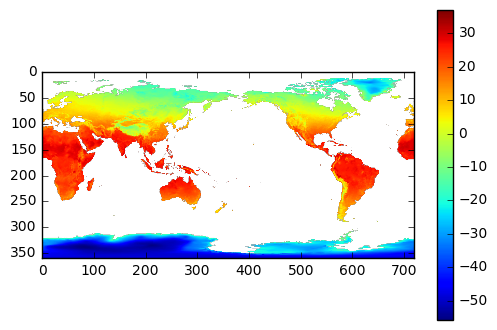

In [8]:
# Расчитаем климатическую норму среднегодовой температуры воздуха
air_mt = air.mean(axis=0)

# Отобразим наши данные стандартыми средствами рисования matplotlib
plt.imshow(air_mt)
plt.colorbar()

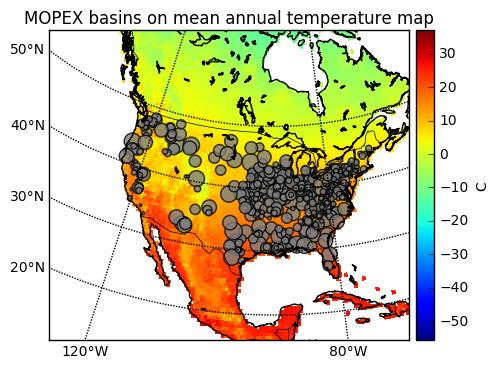

In [9]:
# Для многих задач подойдет и такое отображение данных
# Нам же интересно использовать данные по температуре в качестве подложки для карты

# Создаем основу
m = Basemap(projection='lcc', 
            lat_0 = np.mean(basin_list['lat'].values), 
            lon_0 = np.mean(basin_list['long'].values),
            llcrnrlon=-125.0, llcrnrlat=10.0,
            urcrnrlon=-50.0, urcrnrlat=60.0,
            resolution='l')

x, y = m(basin_list['long'].values, basin_list['lat'].values)

# Для работы с отображением сеточной информации нам нужно трансформировать координаты из векторов в двумерный массив
lon2, lat2 = np.meshgrid(lon,lat)

# Трансформируем координаты
x2, y2 = m(lon2, lat2)

# Добавляем красоты
m.drawcoastlines()
m.drawcountries()
m.drawparallels(np.arange(20, 60, 10), labels=[1, 0, 0, 1])
m.drawmeridians(np.arange(-120, 20, 40), labels=[1, 0, 0, 1])

# Создаем карту распределения среднегодовой температуры
tm = m.pcolor(x2, y2, air_mt)

# Создаем шкалу к температурной карте
cbar = m.colorbar(tm, location='right')
cbar.set_label('C')

# В той же области рисования создаем нашу карту с точками
m.scatter(x,y, 
          s=basin_list['area']/basin_list['area'].min(),
          c='gray',
          alpha=0.8
         )

# Создаем заголовок карты
plt.title('MOPEX basins on mean annual temperature map')

Теперь вы знаете как создать географическую карту с помощью Basemap.

## Способ второй (стильный, модный, молодежный). Folium.

In [10]:
# Импортируем библиотеку для рисования интерактивных карт
# Да, это так просто. Это python.
import folium

In [11]:
# Создаем объект интерактивной карты
# location=[lat, long] - центр нашей карты
# zoom_start=4 - положение зума карты (1-10)
# tiles='OpenStreetMap' - назначение подложки

fm = folium.Map(location=[35, -100], zoom_start=4, tiles="OpenStreetMap")

# последовательно добавляем маркеры координат наших бассейнов к карте
for index, row in basin_list.iterrows():
    location = [row['lat'], row['long']]
    folium.Marker(location=location, popup=row['ID']).add_to(fm)

In [12]:
# запускаем отрисовку интерактивной карты
fm